In [1]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol_encode import Protocol_Embedding
from HINT.model import HINTModel 
device = torch.device("cpu")  ## cuda:0
if not os.path.exists("figure"):
    os.makedirs("figure")
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [13]:
### data-provider datasets
base_name = 'phase_III' ### 'toy', 'phase_I', 'phase_II', 'phase_III', 'indication'
datafolder = "data" ### '/data/clinical-trial-outcome-prediction/data/'
train_file = os.path.join(datafolder, base_name + '_train.csv')
valid_file = os.path.join(datafolder, base_name + '_valid.csv')
test_file = os.path.join(datafolder, base_name + '_test.csv')

train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [ ]:
# ### Leo's datasets
# base_name = 'phase_III' ### 'toy', 'phase_I', 'phase_II', 'phase_III', 'indication'
# datafolder = "/data/clinical-trial-outcome-prediction/data/"
# train_file = os.path.join(datafolder, base_name + '_train.csv')
# valid_file = os.path.join(datafolder, base_name + '_valid.csv')
# test_file = os.path.join(datafolder, base_name + '_test.csv')

# train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
# valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
# test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [3]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = Protocol_Embedding(output_dim = 50, highway_num=3, device = device)

molecule_encoder = mpnn_model
disease_encoder = gram_model
protocol_encoder = protocol_model

In [4]:
def get_embed(dataloader):
    nctid_lst, label_lst, smiles_lst2, icdcode_lst3, criteria_lst = [], [], [], [], []
    for nctid, label, smiles, icdcode, criteria in dataloader:
        nctid_lst.extend(nctid)
        label_lst.extend([i.item() for i in label])
        smiles_lst2.extend(smiles)
        icdcode_lst3.extend(icdcode)
        criteria_lst.extend(criteria)
        
    molecule_embed = molecule_encoder.forward_smiles_lst_lst(smiles_lst2)
    icd_embed = disease_encoder.forward_code_lst3(icdcode_lst3)
    protocol_embed = protocol_encoder.forward(criteria_lst)
    print(molecule_embed.shape, icd_embed.shape, protocol_embed.shape)
    return molecule_embed, icd_embed, protocol_embed

In [5]:
def preprocess(file, loader):
    df = pd.read_csv(file)
    df.drop(['phase', 'why_stop'], axis=1, inplace=True)
    df.drop(['icdcodes', 'smiless', 'criteria'], axis=1, inplace=True)
    df.drop(['diseases', 'drugs'], axis=1, inplace=True) ## FE later
    
    molecule_embed, icd_embed, protocol_embed = get_embed(loader)

    molecule_df = pd.DataFrame(molecule_embed.detach().numpy(), columns=[f'molecule_feature_{i}' for i in range(len(molecule_embed[0]))])
    icd_df = pd.DataFrame(icd_embed.detach().numpy(), columns=[f'icd_feature_{i}' for i in range(len(icd_embed[0]))])
    protocol_df = pd.DataFrame(protocol_embed.detach().numpy(), columns=[f'protocol_feature_{i}' for i in range(len(protocol_embed[0]))])

    df = pd.concat([df, molecule_df, icd_df, protocol_df], axis=1)
    return df

In [14]:
train_df = preprocess(train_file, train_loader)
valid_df = preprocess(valid_file, valid_loader)
test_df = preprocess(test_file, test_loader)
print(train_df.shape, valid_df.shape, test_df.shape)

torch.Size([3094, 50]) torch.Size([3094, 50]) torch.Size([3094, 50])
torch.Size([344, 50]) torch.Size([344, 50]) torch.Size([344, 50])
torch.Size([1146, 50]) torch.Size([1146, 50]) torch.Size([1146, 50])
(3094, 153) (344, 153) (1146, 153)


In [15]:
train_idx = range(len(train_df))
valid_idx = range(len(train_df), len(train_df) + len(valid_df))
test_idx = range(len(train_df) + len(valid_df), len(train_df) + len(valid_df) + len(test_df))

combined_df = pd.DataFrame()
combined_df = pd.concat([train_df, valid_df, test_df], axis=0)
combined_df.reset_index(drop=True, inplace=True)
combined_df = pd.get_dummies(combined_df, columns=['status'], drop_first=True)

train_clean = combined_df.loc[train_idx]
valid_clean = combined_df.loc[valid_idx]
test_clean = combined_df.loc[test_idx]

In [16]:
X_train, y_train = train_clean.drop(['nctid','label'], axis=1), train_clean['label']  
X_valid, y_valid = valid_clean.drop(['nctid','label'], axis=1), valid_clean['label']  
X_test, y_test = test_clean.drop(['nctid','label'], axis=1), test_clean['label']  
print(X_train.shape, X_valid.shape, X_test.shape)

(3094, 156) (344, 156) (1146, 156)


In [17]:
X_test.isnull().sum().sort_values(ascending=False)  # no missing data

molecule_feature_0    0
protocol_feature_7    0
protocol_feature_0    0
protocol_feature_1    0
protocol_feature_2    0
                     ..
icd_feature_2         0
icd_feature_3         0
icd_feature_4         0
icd_feature_5         0
status_withdrawn      0
Length: 156, dtype: int64

In [18]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, precision_score, recall_score, auc

start_time = time.time()
# model = xgb.XGBClassifier(n_estimators=100, random_state=42) 
model = xgb.XGBClassifier(random_state=42)
hyperparameters = {
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'alpha': [5, 10, 15],
    'n_estimators': [100, 200]
}
grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring='accuracy')  # 'accuracy', 'roc_auc'
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
# model.fit(X_train, y_train)
print("time is ", time.time()-start_time)

{'alpha': 5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.7663158555139044
time is  1066.2498245239258


In [19]:
from sklearn.metrics import accuracy_score
model = grid_search.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)
print(accuracy_score(y_pred_train, y_train))
print(accuracy_score(y_pred_valid, y_valid))
print(accuracy_score(y_pred_test, y_test))

0.7766645119586296
0.7645348837209303
0.7853403141361257


In [20]:
def print_metrics(y_true, y_pred, label):
    print(f"{label} ROC AUC: {round(roc_auc_score(y_true, y_pred),3)}")
    print(f"{label} F1: {round(f1_score(y_true, y_pred),3)}")
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print(f"{label} PR-AUC: {round(auc(recall, precision),3)}")
    print(f"{label} Precision: {round(precision_score(y_true, y_pred),3)}")
    print(f"{label} Recall: {round(recall_score(y_true, y_pred),3)}")
    print(f"{label} Accuracy: {round(accuracy_score(y_true, y_pred),3)}")
    print(f"{label} Predict 1 ratio: {round(sum(y_pred) / len(y_pred),3)}")
    print(f"{label} Label 1 ratio: {round(sum(y_true) / len(y_true),3)}")

# print_metrics(y_train, y_pred_train, 'Train')
# print_metrics(y_valid, y_pred_valid, 'Valid')
print_metrics(y_test, y_pred_test, 'Test')

Test ROC AUC: 0.712
Test F1: 0.857
Test PR-AUC: 0.91
Test Precision: 0.855
Test Recall: 0.859
Test Accuracy: 0.785
Test Predict 1 ratio: 0.753
Test Label 1 ratio: 0.75


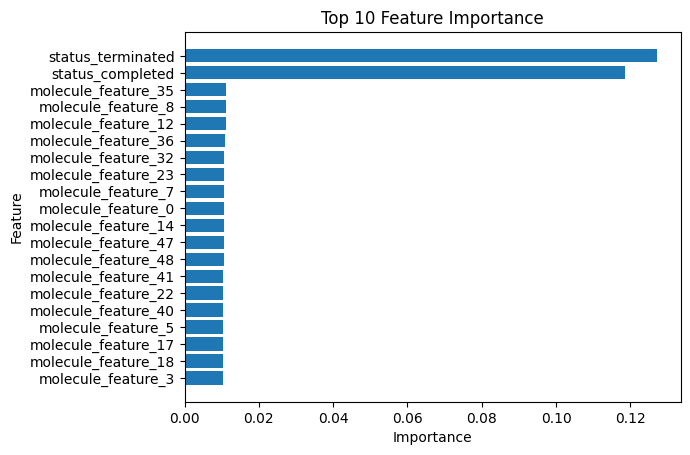

In [13]:
feature_model = RandomForestClassifier(n_estimators=100, random_state=42)
feature_model.fit(X_train, y_train)
feature_importance = feature_model.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.barh(importance_df['feature'][:20], importance_df['importance'][:20]) 
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  
plt.show()